In [136]:
# To initialise all the libraries you need for this notebook run the below code. 
# This is to be used when you are jumping through the document

import numpy as np
from numpy import sin,cos,exp, pi,log, log10, ceil
np.set_printoptions(precision=6,suppress=True,threshold=10)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,3)
import matplotlib.style as plt_style
plt_style.use("ggplot")
import matplotlib.dates as mdates

import csv
import datetime as dt
from statistics import mean

## <center> UNIVERSITY COLLEGE DUBLIN </center>
## <center> SCHOOL OF ELECTRICAL, ELECTRONIC & COMMUNICATIONS ENG. </center>
## <center> FINAL YEAR PROJECT</center>
### <center> James Carron </center>
## <center> EVs and the Grid </center>

Report by: 


<center>James Carron:  15333196

### Notes to self:
 - All values are in MW or MWh

In [241]:
def areaundercurve(data,hline,interval=0.25):
    total = 0.0
    for value in data:
        if value > hline:
            total += (value-hline)*interval
    return total

def areaabovecurve(data,hline,interval=0.25):
    total = 0.0
    for value in data:
        if value < hline:
            total += (hline-value)*interval
    return total

In [169]:
CSVFILE = 'EirGridData050118.csv'
#CSVFILE = 'EirGridData180218.csv'

with open(CSVFILE, 'rb') as csvfile:
    EirGridCsv = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(EirGridCsv) #skip the header
    
    #remove extra quote marks and convert to str to int
    EirGridData = [[row[0].replace('"', ''), int(row[1])] for row in EirGridCsv]

EirGridDate = [item[0] for item in EirGridData]    
EirGridValue = [item[1] for item in EirGridData]  

for i, value in enumerate(EirGridDate):
    EirGridDate[i] = dt.datetime.strptime(str(value), "%Y-%m-%d %H:%M:%S")
    
print("{}:".format(EirGridDate[0].date()))    
    
MeanUsage = mean(EirGridValue)
print("Mean: \t{:.2f} MW".format(MeanUsage))

TotalUsage = sum(EirGridValue)*0.25
print("Total: \t{:.2f} GWh".format(TotalUsage/(1000.0)))

UsageRange = max(EirGridValue)-min(EirGridValue)
print("Range: \t{} MW".format(UsageRange))

2018-01-05:
Mean: 	4716.21 MW
Total: 	113.19 GWh
Range: 	2727 MW


Battery Capacity stats:
https://en.wikipedia.org/wiki/Electric_vehicle_battery

From this I assume a 50kW battery pack as standard

In [260]:
BattPercUsage = 0.25
BatteryCapacity = 50*(10**-3)
NumUsers = 20000.0

CapacityAvailable = BattPercUsage*BatteryCapacity*NumUsers
print("Capacity Available: {:.0F} MWh".format(CapacityAvailable))

UsersNeeded = ceil(areaundercurve(EirGridValue,MeanUsage)/(BattPercUsage*BatteryCapacity))
print("Users Needed to smooth Peaks: {:.0f}".format(UsersNeeded))

Capacity Available: 250 MWh
Users Needed to smooth Peaks: 698347


In [261]:
wbatterypeak = max(EirGridValue)
while True:
    
    error = CapacityAvailable - areaundercurve(EirGridValue,wbatterypeak-1) #test next value
    if error < 0:
        error = CapacityAvailable - areaundercurve(EirGridValue,wbatterypeak)
        break
    else:
        wbatterypeak -= 1
print("Peak   w/ Batteries: {}MW, \tLeeway: {} MWh".format(wbatterypeak,error))

wbatterytrough = min(EirGridValue)
while True:
    error = CapacityAvailable - areaabovecurve(EirGridValue,wbatterytrough+1) #test next value
    
    if error < 0:
        error = CapacityAvailable - areaabovecurve(EirGridValue,wbatterytrough)
        break
    else:
        wbatterytrough += 1
        
print("Trough w/ Batteries: {}MW, \tLeeway: {} MWh".format(wbatterytrough,error))

wbatteryrange = topline - bottomline
print("Range: \t{} MW".format(wbatteryrange))

PeakPowerDraw = (max(EirGridValue)-wbatterypeak)/NumUsers
print("Peak Power draw per EV: {} kW".format(PeakPowerDraw*1000))

MaxChargingRate = (bottomline-min(EirGridValue))/NumUsers
print("Max Charge rate per EV: {} kW".format(MaxChargingRate*1000))

Rangereduction = UsageRange - wbatteryrange
Rangereductionperc = (UsageRange - wbatteryrange) / float(UsageRange)
print("Variance Reduction: {:.2f}MW, {:.0%}%".format(Rangereduction,Rangereductionperc))

Peak   w/ Batteries: 5883MW, 	Leeway: 0.5 MWh
Trough w/ Batteries: 3496MW, 	Leeway: 2.5 MWh
Range: 	1289 MW
Peak Power draw per EV: 11.15 kW
Max Charge rate per EV: 28.35 kW
Variance Reduction: 1438.00MW, 53%%


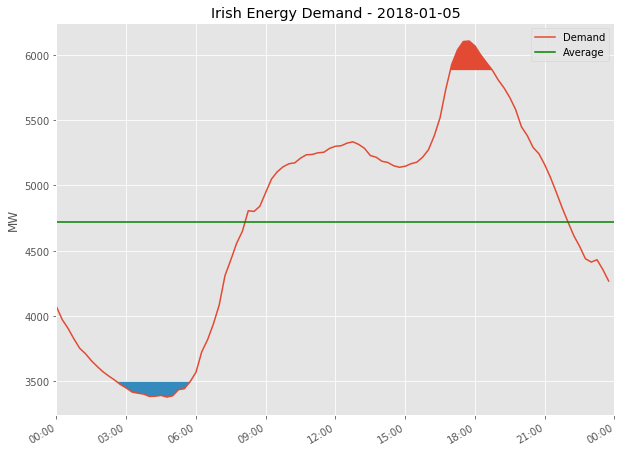

2018-01-05:
Mean: 	4716.21 MW
Total: 	113.19 GWh
Range: 	2727 MW
Peak   w/ Batteries: 5883MW, 	Leeway: 2.5 MWh
Trough w/ Batteries: 3496MW, 	Leeway: 2.5 MWh
Range: 	1289 MW
Peak Power draw per EV: 11.15 kW
Max Charge rate per EV: 28.35 kW


In [262]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(EirGridDate,EirGridValue,ls="-",label = "Demand")
ax.axhline(MeanUsage, color="g",label = "Average")

#Shading in battery effect

# PEAK
#ax.axhline(wbatterypeak, color="r",label = "hline")
boolarray = list()
for value in EirGridValue:
    if value > wbatterypeak:
        boolarray.append(True)
    else:
        boolarray.append(False)
        
ax.fill_between(EirGridDate, wbatterypeak, EirGridValue, where= boolarray, interpolate=True)     

# TROUGH
#ax.axhline(wbatterytrough, color="b",label = "hline")
boolarray = list()
for value in EirGridValue:
    if value < wbatterytrough:
        boolarray.append(True)
    else:
        boolarray.append(False)

ax.fill_between(EirGridDate, wbatterytrough, EirGridValue, where= boolarray, interpolate=True)
        
        
plt.title("Irish Energy Demand - {}".format(EirGridDate[0].date()))
plt.ylabel("MW")
plt.legend()

#format the ticks
myFmt = mdates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlim(EirGridDate[0], EirGridDate[-1]+ dt.timedelta(minutes=15))
plt.gcf().autofmt_xdate()

plt.show()

print("{}:".format(EirGridDate[0].date()))    
print("Mean: \t{:.2f} MW".format(MeanUsage))
print("Total: \t{:.2f} GWh".format(TotalUsage/(1000.0)))
print("Range: \t{} MW".format(UsageRange))

print("Peak   w/ Batteries: {}MW, \tLeeway: {} MWh".format(wbatterypeak,error))
print("Trough w/ Batteries: {}MW, \tLeeway: {} MWh".format(wbatterytrough,error))
print("Range: \t{} MW".format(wbatteryrange))

print("Peak Power draw per EV: {} kW".format(PeakPowerDraw*1000))
print("Max Charge rate per EV: {} kW".format(MaxChargingRate*1000))
